In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import glob
import os
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
import cv2
import torch.fft
import math
import random

In [2]:
image_size = 256

def create_random_mask(image_size, max_shapes=3, min_size=20, max_size=100):
    mask = np.ones((image_size, image_size, 3), dtype=np.float32)

    num_shapes = random.randint(1, max_shapes)

    for _ in range(num_shapes):
        shape_type = random.choice(['rectangle', 'circle', 'ellipse'])

        x = random.randint(0, image_size - min_size)
        y = random.randint(0, image_size - min_size)
        w = random.randint(min_size, max_size)
        h = random.randint(min_size, max_size)

        if shape_type == 'rectangle':
            cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 0), -1)
        elif shape_type == 'circle':
            r = min(w, h) // 2
            cv2.circle(mask, (x + r, y + r), r, (0, 0, 0), -1)
        elif shape_type == 'ellipse':
            angle = random.randint(0, 360)
            axes = (w // 2, h // 2)
            center = (x + w // 2, y + h // 2)
            cv2.ellipse(mask, center, axes, angle, 0, 360, 0, -1)

    return mask

class ImageDataset(Dataset):
    def __init__(self, paths, transform=None, masked_size=100):
        self.paths = paths
        self.transform = transform
        self.masked_size = masked_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        masked_img = img.copy()
        masked_img = np.array(masked_img)
        
        if self.transform:
            img = self.transform(img)

        if self.masked_size:
            mask = create_random_mask(image_size)
            mask = torch.from_numpy(mask)
            mask = mask.permute(2, 0, 1)
            masked_img = Image.fromarray(masked_img)
            masked_img = self.transform(masked_img)
            masked_img = masked_img * mask

        return img, masked_img, mask
    
    @staticmethod
    def collate_fn(batch):
        image, masked_image, mask = zip(*batch)
        image = torch.stack(image, dim=0)
        masked_image = torch.stack(masked_image, dim=0)
        mask = torch.stack(mask, dim=0)
        return image, masked_image, mask

    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dir = "testSet_resize"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))  # Adjust the file extension if needed

train_dataset = ImageDataset(image_paths, transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=ImageDataset.collate_fn, pin_memory=True)


In [3]:
class DownscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownscaleBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return x + self.conv(x)

class UpscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downscale1 = nn.Sequential(
            DownscaleBlock(6, 64),
            DownscaleBlock(64, 128),
            DownscaleBlock(128, 256),
        )
        self.residual1 = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
        )
        self.upscale1 = nn.Sequential(
            UpscaleBlock(256, 128),
            UpscaleBlock(128, 64),
            UpscaleBlock(64, 3),
        )
        self.downscale2 = nn.Sequential(
            DownscaleBlock(6, 64),
            DownscaleBlock(64, 128),
            DownscaleBlock(128, 256),
        )
        self.residual2 = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
        )
        self.upscale2 = nn.Sequential(
            UpscaleBlock(256, 128),
            UpscaleBlock(128, 64),
            UpscaleBlock(64, 3),
        )

    def forward(self, x, mask):
        x_masked = x * mask
        x1 = torch.cat((x_masked, mask), dim=1)
        x1 = self.downscale1(x1)
        x1 = self.residual1(x1)
        x1 = self.upscale1(x1)
        inpainted = x_masked + x1 * (1 - mask)
        x2 = torch.cat((inpainted, mask), dim=1)
        x2 = self.downscale2(x2)
        x2 = self.residual2(x2)
        x2 = self.upscale2(x2)
        refined = inpainted + x2 * (1 - mask)
        return refined

class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(LocalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            DownscaleBlock(3, 64),
            DownscaleBlock(64, 128),
            DownscaleBlock(128, 256),
            DownscaleBlock(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

class GlobalDiscriminator(nn.Module):
    def __init__(self):
        super(GlobalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            DownscaleBlock(3, 64),
            DownscaleBlock(64, 128),
            DownscaleBlock(128, 256),
            DownscaleBlock(256, 512),
            DownscaleBlock(512, 1024),
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.local_discriminator = LocalDiscriminator()
        self.global_discriminator = GlobalDiscriminator()
        self.fc = nn.Linear(194, 1)

    def forward(self, inpainted_image, inpainted_mask):
        local_output = self.local_discriminator(inpainted_mask)
        global_output = self.global_discriminator(inpainted_image)
        combined_output = torch.cat((local_output.view(local_output.size(0), -1), global_output.view(global_output.size(0), -1)), dim=1)
        output = self.fc(combined_output)
        return torch.sigmoid(output)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

MSE = nn.MSELoss()
L1 = nn.L1Loss()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001 , betas=(0.5, 0.999))

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    for images, masked_images, masks in train_loader:
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

        d_optimizer.zero_grad()

        inpainted = generator(images, masks)
        image_masks = images * (1 - masks)
        real_output = discriminator(images, image_masks)
        inpainted_image = inpainted.detach()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted_image, inpainted_image_masks)

        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output, device=device)

        d_real_loss = MSE(real_output, real_labels)
        d_fake_loss = MSE(fake_output, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted, inpainted_image_masks)

        g_loss_adv = MSE(fake_output, real_labels)
        g_loss_l1 = L1(inpainted, images)
        g_loss = g_loss_adv + g_loss_l1 * 100
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}] D_loss: {d_loss.item()} G_loss: {g_loss.item()}")



 10%|██████████████                                                                                                                               | 1/10 [04:55<44:22, 295.79s/it]

Epoch [1/10] D_loss: 0.5 G_loss: 5.730940818786621


 20%|████████████████████████████▏                                                                                                                | 2/10 [10:32<42:40, 320.02s/it]

Epoch [2/10] D_loss: 0.5 G_loss: 6.249283313751221


 30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [16:25<39:03, 334.81s/it]

Epoch [3/10] D_loss: 0.5 G_loss: 4.964599132537842


 40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [22:17<34:10, 341.73s/it]

Epoch [4/10] D_loss: 0.5 G_loss: 5.048115253448486


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [28:09<28:47, 345.60s/it]

Epoch [5/10] D_loss: 0.5 G_loss: 5.334017753601074


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [34:21<23:38, 354.55s/it]

Epoch [6/10] D_loss: 0.5 G_loss: 5.0626630783081055


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [41:41<19:07, 382.42s/it]

Epoch [7/10] D_loss: 0.5 G_loss: 5.819470405578613


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [49:01<13:21, 400.59s/it]

Epoch [8/10] D_loss: 0.5 G_loss: 4.6801347732543945


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [56:20<06:52, 412.72s/it]

Epoch [9/10] D_loss: 0.5 G_loss: 5.7112650871276855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:03:40<00:00, 382.00s/it]

Epoch [10/10] D_loss: 0.512499988079071 G_loss: 4.353344917297363


In [5]:
torch.save(generator.state_dict(), 'generator_new_10.pth')
torch.save(discriminator.state_dict(), 'discriminator_new_10.pth')

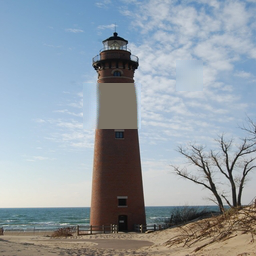

In [6]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_new_10.pth"))
discriminator.load_state_dict(torch.load("discriminator_new_10.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
mask = create_random_mask(256)
mask = torch.from_numpy(mask)
mask = mask.permute(2, 0, 1)
image = transform(image).to("cuda")
mask = mask.to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
image = generator(image, mask)
image = image.squeeze(0)
image = image.detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image)
display(image)

In [7]:
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    for images, masked_images, masks in train_loader:
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

        d_optimizer.zero_grad()

        inpainted = generator(images, masks)
        image_masks = images * (1 - masks)
        real_output = discriminator(images, image_masks)
        inpainted_image = inpainted.detach()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted_image, inpainted_image_masks)

        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output, device=device)

        d_real_loss = MSE(real_output, real_labels)
        d_fake_loss = MSE(fake_output, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted, inpainted_image_masks)

        g_loss_adv = MSE(fake_output, real_labels)
        g_loss_l1 = L1(inpainted, images)
        g_loss = g_loss_adv + g_loss_l1 * 100
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}] D_loss: {d_loss.item()} G_loss: {g_loss.item()}")

 10%|██████████████                                                                                                                               | 1/10 [06:15<56:17, 375.32s/it]

Epoch [1/10] D_loss: 0.512499988079071 G_loss: 5.114754676818848


 20%|████████████████████████████▏                                                                                                                | 2/10 [12:23<49:27, 370.93s/it]

Epoch [2/10] D_loss: 0.5 G_loss: 5.898136138916016


 30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [18:30<43:06, 369.51s/it]

Epoch [3/10] D_loss: 0.5 G_loss: 5.22412109375


 40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [24:38<36:53, 368.84s/it]

Epoch [4/10] D_loss: 0.5 G_loss: 6.014717102050781


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [30:46<30:42, 368.49s/it]

Epoch [5/10] D_loss: 0.512499988079071 G_loss: 5.722075939178467


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [36:54<24:33, 368.28s/it]

Epoch [6/10] D_loss: 0.5 G_loss: 6.32089900970459


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [43:02<18:24, 368.14s/it]

Epoch [7/10] D_loss: 0.5 G_loss: 3.8931474685668945


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [49:10<12:16, 368.03s/it]

Epoch [8/10] D_loss: 0.5 G_loss: 5.18464469909668


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [55:18<06:07, 367.96s/it]

Epoch [9/10] D_loss: 0.5 G_loss: 5.535659313201904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:01:21<00:00, 368.16s/it]

Epoch [10/10] D_loss: 0.5 G_loss: 5.578343391418457


In [8]:
torch.save(generator.state_dict(), 'generator_new_20.pth')
torch.save(discriminator.state_dict(), 'discriminator_new_20.pth')

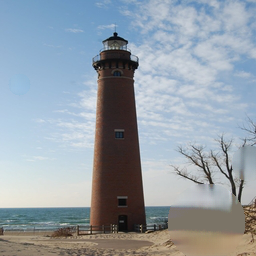

In [9]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_new_20.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
mask = create_random_mask(256)
mask = torch.from_numpy(mask)
mask = mask.permute(2, 0, 1)
image = transform(image).to("cuda")
mask = mask.to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
image = generator(image, mask)
image = image.squeeze(0)
image = image.detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image)
display(image)

In [10]:
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    for images, masked_images, masks in train_loader:
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

        d_optimizer.zero_grad()

        inpainted = generator(images, masks)
        image_masks = images * (1 - masks)
        real_output = discriminator(images, image_masks)
        inpainted_image = inpainted.detach()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted_image, inpainted_image_masks)

        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output, device=device)

        d_real_loss = MSE(real_output, real_labels)
        d_fake_loss = MSE(fake_output, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted, inpainted_image_masks)

        g_loss_adv = MSE(fake_output, real_labels)
        g_loss_l1 = L1(inpainted, images)
        g_loss = g_loss_adv + g_loss_l1 * 100
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}] D_loss: {d_loss.item()} G_loss: {g_loss.item()}")

 10%|██████████████                                                                                                                               | 1/10 [06:12<55:51, 372.37s/it]

Epoch [1/10] D_loss: 0.2500903010368347 G_loss: 6.021216869354248


 20%|████████████████████████████▏                                                                                                                | 2/10 [12:24<49:38, 372.27s/it]

Epoch [2/10] D_loss: 0.25013118982315063 G_loss: 5.641152858734131


 30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [18:36<43:25, 372.25s/it]

Epoch [3/10] D_loss: 0.25021663308143616 G_loss: 6.21648645401001


 40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [24:48<37:13, 372.20s/it]

Epoch [4/10] D_loss: 0.25008514523506165 G_loss: 6.481540203094482


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [31:01<31:01, 372.29s/it]

Epoch [5/10] D_loss: 0.25007444620132446 G_loss: 5.406277656555176


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [37:13<24:48, 372.24s/it]

Epoch [6/10] D_loss: 0.24999742209911346 G_loss: 5.1336469650268555


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [43:25<18:36, 372.30s/it]

Epoch [7/10] D_loss: 0.25004205107688904 G_loss: 5.693554401397705


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [49:38<12:24, 372.26s/it]

Epoch [8/10] D_loss: 0.2500607967376709 G_loss: 5.222897529602051


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [55:50<06:12, 372.27s/it]

Epoch [9/10] D_loss: 0.2500341236591339 G_loss: 5.297730922698975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:01:59<00:00, 371.91s/it]

Epoch [10/10] D_loss: 0.25009608268737793 G_loss: 4.971980094909668


In [11]:
torch.save(generator.state_dict(), 'generator_new_30.pth')
torch.save(discriminator.state_dict(), 'discriminator_new_30.pth')

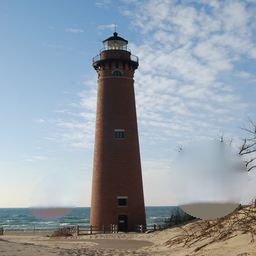

In [12]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_new_30.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
mask = create_random_mask(256)
mask = torch.from_numpy(mask)
mask = mask.permute(2, 0, 1)
image = transform(image).to("cuda")
mask = mask.to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
image = generator(image, mask)
image = image.squeeze(0)
image = image.detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image)
display(image)

In [13]:
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    for images, masked_images, masks in train_loader:
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

        d_optimizer.zero_grad()

        inpainted = generator(images, masks)
        image_masks = images * (1 - masks)
        real_output = discriminator(images, image_masks)
        inpainted_image = inpainted.detach()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted_image, inpainted_image_masks)

        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output, device=device)

        d_real_loss = MSE(real_output, real_labels)
        d_fake_loss = MSE(fake_output, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted, inpainted_image_masks)

        g_loss_adv = MSE(fake_output, real_labels)
        g_loss_l1 = L1(inpainted, images)
        g_loss = g_loss_adv + g_loss_l1 * 100
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}] D_loss: {d_loss.item()} G_loss: {g_loss.item()}")

torch.save(generator.state_dict(), 'generator_new_40.pth')
torch.save(discriminator.state_dict(), 'discriminator_new_40.pth')

 10%|██████████████                                                                                                                               | 1/10 [05:38<50:44, 338.25s/it]

Epoch [1/10] D_loss: 0.25017523765563965 G_loss: 5.367679119110107


 20%|████████████████████████████▏                                                                                                                | 2/10 [11:15<45:02, 337.75s/it]

Epoch [2/10] D_loss: 0.25016218423843384 G_loss: 5.462450981140137


 30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [16:53<39:23, 337.59s/it]

Epoch [3/10] D_loss: 0.250144362449646 G_loss: 6.738925457000732


 40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [22:30<33:46, 337.72s/it]

Epoch [4/10] D_loss: 0.25022605061531067 G_loss: 5.606144905090332


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [28:08<28:08, 337.61s/it]

Epoch [5/10] D_loss: 0.2502422630786896 G_loss: 5.1450371742248535


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [33:46<22:30, 337.74s/it]

Epoch [6/10] D_loss: 0.25017082691192627 G_loss: 5.953649997711182


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [39:23<16:52, 337.62s/it]

Epoch [7/10] D_loss: 0.2501819133758545 G_loss: 5.462491512298584


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [45:01<11:15, 337.74s/it]

Epoch [8/10] D_loss: 0.2501913607120514 G_loss: 6.810247898101807


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [50:39<05:37, 337.62s/it]

Epoch [9/10] D_loss: 0.2502245306968689 G_loss: 6.474050521850586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [56:16<00:00, 337.65s/it]

Epoch [10/10] D_loss: 0.25023818016052246 G_loss: 4.701862812042236


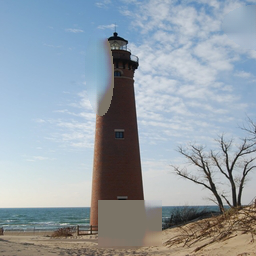

In [14]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_new_40.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
mask = create_random_mask(256)
mask = torch.from_numpy(mask)
mask = mask.permute(2, 0, 1)
image = transform(image).to("cuda")
mask = mask.to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
image = generator(image, mask)
image = image.squeeze(0)
image = image.detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image)
display(image)

In [15]:
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    for images, masked_images, masks in train_loader:
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

        d_optimizer.zero_grad()

        inpainted = generator(images, masks)
        image_masks = images * (1 - masks)
        real_output = discriminator(images, image_masks)
        inpainted_image = inpainted.detach()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted_image, inpainted_image_masks)

        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output, device=device)

        d_real_loss = MSE(real_output, real_labels)
        d_fake_loss = MSE(fake_output, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        inpainted_image_masks = inpainted_image * (1 - masks)
        fake_output = discriminator(inpainted, inpainted_image_masks)

        g_loss_adv = MSE(fake_output, real_labels)
        g_loss_l1 = L1(inpainted, images)
        g_loss = g_loss_adv + g_loss_l1 * 100
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}] D_loss: {d_loss.item()} G_loss: {g_loss.item()}")

torch.save(generator.state_dict(), 'generator_new_50.pth')
torch.save(discriminator.state_dict(), 'discriminator_new_50.pth')

 10%|██████████████                                                                                                                               | 1/10 [05:49<52:26, 349.62s/it]

Epoch [1/10] D_loss: 0.2502272427082062 G_loss: 4.840445041656494


 20%|████████████████████████████▏                                                                                                                | 2/10 [11:53<47:44, 358.04s/it]

Epoch [2/10] D_loss: 0.25017866492271423 G_loss: 6.488255500793457


 30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [17:57<42:05, 360.81s/it]

Epoch [3/10] D_loss: 0.250299334526062 G_loss: 6.389681816101074


 40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [24:01<36:12, 362.04s/it]

Epoch [4/10] D_loss: 0.25028282403945923 G_loss: 5.93920373916626


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [30:06<30:14, 362.97s/it]

Epoch [5/10] D_loss: 0.2502194046974182 G_loss: 4.519398212432861


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [36:10<24:13, 363.31s/it]

Epoch [6/10] D_loss: 0.25022125244140625 G_loss: 5.8522162437438965


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [42:14<18:10, 363.51s/it]

Epoch [7/10] D_loss: 0.2502291798591614 G_loss: 3.947866201400757


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [48:18<12:07, 363.74s/it]

Epoch [8/10] D_loss: 0.25019437074661255 G_loss: 4.934121608734131


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [54:30<06:06, 366.39s/it]

Epoch [9/10] D_loss: 0.25025153160095215 G_loss: 5.218959331512451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [58:54<00:00, 353.40s/it]

Epoch [10/10] D_loss: 0.2501351833343506 G_loss: 5.620638847351074


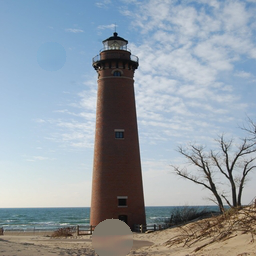

In [16]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_new_50.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
mask = create_random_mask(256)
mask = torch.from_numpy(mask)
mask = mask.permute(2, 0, 1)
image = transform(image).to("cuda")
mask = mask.to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
image = generator(image, mask)
image = image.squeeze(0)
image = image.detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image)
display(image)

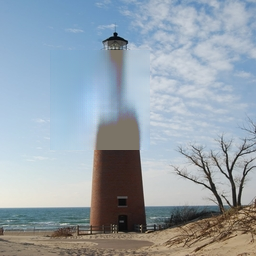

In [17]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_new_50.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
mask = np.ones((3, 256, 256), dtype=np.uint8)
mask[:, 50:150, 50:150] = 0
mask = torch.from_numpy(mask)
image = transform(image).to("cuda")
mask = mask.to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
image = generator(image, mask)
image = image.squeeze(0)
image = image.detach().cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image)
display(image)